In a [previous post, the Black-Scholes option pricing formula](https://aaronschlegel.me/black-scholes-formula-python.html) for a non-dividend and dividend-paying European stock option was introduced. In actuality, there exist several extensions of the model that are used for pricing European options with different underlying assets, such as currency, futures, stock indexes, and more.

Due to the number of different extensions and options on possible underlying assets, a generalized Black-Scholes model was created to simplify computations by significantly reducing the number of equations. In this post, we will explore several of the Black-Scholes option pricing models for different underlying assets and then introduce the generalized Black-Scholes pricing formula.

First, import the libraries and functions that we will use later in the post.

In [1]:
import numpy as np
from scipy import stats
import sympy
from sympy.stats import Normal, cdf
from sympy import init_printing
init_printing()

### Futures Options

The Black-Scholes option pricing formula for European forward or futures options with an initial price $F$ was proposed by Black himself in 1976. Hence the name of the equation is generally known as the 'Black-76' formula and is defined as:

$$ C = e^{-rT} \big[ FN(d_1) - KN(d_2) \big] $$

$$ P = e^{-rT} \big[KN(-d_2) - FN(-d_1)\big] $$

Where, as before:

* $T$, the maturity of the option. Time to maturity is defined as $T - t$
* $K$, strike price of the option
* $r$, the risk-free interest rate, assumed to be constant between $t$ and $T$
* $\sigma$, volatility of underlying asset, the standard deviation of the asset returns
* $N(d)$ is the [normal cumulative distribution function](https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function), and $d_1$ and $d_2$ are defined as:

$$d_1 = \frac{\ln \left(\frac{F}{K} \right) + T \left(\frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}}$$

$$d_2 = \frac{\ln \left(\frac{F}{K} \right) - T \left(\frac{\sigma^2}{2}\right)}{\sigma \sqrt{T}} = d_1 - \sigma \sqrt{T} $$

A possible implementation in Python of the Black-Scholes-76 model for pricing European futures options for approximate and exact results is as follows:

In [2]:
def black_scholes76(f, k, r, sigma, t, option='call', exact=False):
    if option not in ('call', 'put'):
        raise ValueError('option parameter must be one of "call" (default) or "put".')
        
    if exact:
        d1 = (sympy.ln(f / k) + t * (sigma ** 2 / 2)) / (sigma * sympy.sqrt(t))
        d2 = d1 - sigma * sympy.sqrt(t)        
    
        n = Normal("x", 0.0, 1.0)
    
        if option == 'call':
            price = sympy.exp(-r * t) * (f * cdf(n)(d1) - k * cdf(n)(d2))
        elif option == 'put':
            price = sympy.exp(-r * t) * (k * cdf(n)(-d2) - f * cdf(n)(-d1))
        
    else:
        d1 = (np.log(f / k) + (sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        
        if option == 'call':
            price = np.exp(-r * t) * (f * stats.norm.cdf(d1) - k * stats.norm.cdf(d2))
        elif option == 'put':
            price = np.exp(-r * t) * (k * stats.norm.cdf(-d2) - f * stats.norm.cdf(-d1))
        
    return price

As an example, consider a futures contract with nine months to expiration. The price of the futures contract and the strike price is `$20`, with a risk-free interest rate of 15% and a volatility of 40% per year. To find the price of the futures contract, we enter these variables into the above function.

In [3]:
f = 20
k = 20
r = .15
t = 9 / 12
sigma = 0.40

In [4]:
print('Call Option Price')
print(black_scholes76(f, k, r, sigma, t, option='call'))

print('Put Option Price')
print(black_scholes76(f, k, r, sigma, t, option='put'))

Call Option Price
2.4575673110408576
Put Option Price
2.4575673110408576


Thus, we see that the call and put price for the futures contract is the same. We can also get the exact solution by setting the `exact` parameter to `True`.

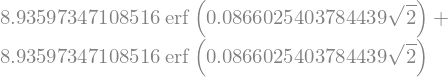

In [5]:
black_scholes76(f, k, r, sigma, t, exact=True)

### Stock Index Options

Robert Merton, who was working with Fischer Black and Myron Scholes on their now famous equation until a difference in opinion led to them to part ways, extended the Black-Scholes model to price European call and put options on a stock or stock index paying a known continuous dividend yield. 

$$ C = Se^{-qT} N(d_1) - Ke^{-rT} N(d_2) $$

$$ P = Ke^{-rT} N(-d_2) - Se^{-qT} N(d_1) $$

Where $q$ is the known dividend yield and:

$$ d_1 = \frac{\ln \left( \frac{S}{K} \right) + T \left(r - q + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}} $$

$$ d_2 = \frac{\ln \left( \frac{S}{K} \right) + T \left(r - q - \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}} = d_1 - \sigma \sqrt{T} $$

One possible implementation (a rough and unoptimized one) of Merton's extension to the Black-Scholes formula for both approximate and exact results

In [6]:
def black_scholes_merton(s, k, r, q, sigma, t, option='call', exact=False):
    if option not in ('call', 'put'):
        raise ValueError('option parameter must be one of "call" (default) or "put".')
        
    if exact:
        d1 = (sympy.ln(s / k) + t * (r - q + sigma ** 2 / 2)) / (sigma * sympy.sqrt(t))
        d2 = d1 - sigma * sympy.sqrt(t)
        
        n = Normal("x", 0.0, 1.0)
        
        if option == 'call':
            price = s * sympy.exp(-q * t) * cdf(n)(d1) - k * sympy.exp(-r * t) * cdf(n)(d2)
        elif option == 'put':
            price = k * sympy.exp(-r * t) * cdf(n)(-d2) - s * sympy.exp(-q * t) * cdf(n)(-d1)
          
    else:
        d1 = (np.log(s / k) + t * (r - q + sigma ** 2 / 2)) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        
        if option == 'call':
            price = s * np.exp(-q * t) * stats.norm.cdf(d1) - k * np.exp(-r * t) * stats.norm.cdf(d2)
        elif option == 'put':
            price = k * np.exp(-r * t) * stats.norm.cdf(-d2) - s * np.exp(-q * t) * stats.norm.cdf(-d1)
            
    return price

To see if our newly created function works as intended, consider a European option with six months to expiration. The index of the stock is `$110` with a strike price of `$100`, a risk-free interest rate of 10% and an 8% dividend yield and 25% volatility.

In [7]:
s = 110
k = 100
r = 0.10
q = 0.08
t = 6 / 12
sigma = 0.25

In [8]:
print('Call Option Price')
print(black_scholes_merton(s, k, r, q, sigma, t, option='call'))

print('Put Option Price')
print(black_scholes_merton(s, k, r, q, sigma, t, option='put'))

Call Option Price
13.568091317729753
Put Option Price
3.0041954610456045


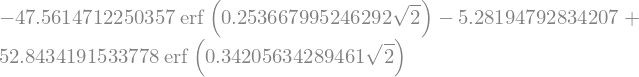

In [9]:
black_scholes_merton(s, k, r, q, sigma, t, option='put', exact=True)

### Currency Options

The Black-Scholes model can also be extended to price European currency call and put options. The model is quite similar to Merton's version described above, except the dividend yield $q$ is instead a risk-free rate of the foreign currency, noted as $r_f$. 

$$ C = Se^{-r_f T} N(d_1) - Ke^{-rT} N(d_2) $$

$$ P = Ke^{-rT} N(-d_2) - Se^{-r_f T} N(-d_1) $$

Where, 

$$ d_1 = \frac{\frac{S}{K} + T \left(r - r_f + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}} $$

$$ d_2 = \frac{\frac{S}{K} + T \left(r - r_f - \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}} = d_1 - \sigma \sqrt{T} $$

In [10]:
def black_scholes_currency(s, k, r, rf, sigma, t, option='call', exact=False):
    if option not in ('call', 'put'):
        raise ValueError('option parameter must be one of "call" (default) or "put".')
        
    if exact:
        d1 = (sympy.ln(s / k) + t * (r - rf + sigma ** 2 / 2)) / (sigma * sympy.sqrt(t))
        d2 = d1 - sigma * sympy.sqrt(t)
        
        n = Normal("x", 0.0, 1.0)
        
        if option == 'call':
            price = s * sympy.exp(-rf * t) * cdf(n)(d1) - k * sympy.exp(-r * t) * cdf(n)(d2)
        elif option == 'put':
            price = k * sympy.exp(-r * t) * cdf(n)(-d2) - s * sympy.exp(-rf * t) * cdf(n)(-d1)
            
    else:
        d1 = (np.log(s / k) + t * (r - rf + sigma ** 2 / 2)) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        
        if option == 'call':
            price = s * np.exp(-rf * t) * stats.norm.cdf(d1) - k * np.exp(-r * t) * stats.norm.cdf(d2)
        elif option == 'put':
            price = k * np.exp(-r * t) * stats.norm.cdf(-d2) - s * np.exp(-rf * t) * stats.norm.cdf(-d1)
            
    return price

As another example, let's say we have a currency option that is set to expire in six months. The exchange rate of the currency is `$2`, and the strike is `$2.5`, with a 5% domestic risk-free interest rate and an 8% risk-free interest return in the foreign currency and a 20% volatility.

In [11]:
s = 2
k = 2.5
t = 6 / 12
r = 0.05
rf = 0.08
sigma = 0.20

In [12]:
print('Call Option Price')
print(black_scholes_currency(s, k, r, rf, sigma, t, option='call'))

print('Put Option Price')
print(black_scholes_currency(s, k, r, rf, sigma, t, option='put'))

Call Option Price
0.005810283556875531
Put Option Price
0.5225061853230608


In [13]:
print(black_scholes_currency(s, k, r, rf, sigma, t, option='call'))

0.005810283556875531


### Generalized Black-Scholes Model

As we've seen, there are quite a few different extensions of the original Black-Scholes formula for European options with various underlying securities, and this was only a sample! Wouldn't it be great if we could find a generalized form of the Black-Scholes model that applies to multiple European options rather than having to memorize and program a bunch of different model forms? Luckily for us, there does exist a generalized form! The generalized Black-Scholes model can be used to price European call and put options on stocks, stocks paying a dividend, futures, margined futures, and currency. This generalization is accomplished by adding a new variable $b$, which is defined as the cost-of-carry rate. The cost-of-carry rate calculation is dependent on the type of option one wishes to price.

* $b = r$
  - Black-Scholes model for European stock options
* $b = r - q$
  - Merton's extension to the model for pricing European stock options with a continuous dividend yield and stock indexes
* $b = 0$
  - Black Fischer's extension for pricing European futures options
* $b = r - r_j$ 
  - Model for pricing European currency options
  
The generalized Black-Scholes model for a European call and put option is defined as:

$$ C = Se^{T(b-r)} N(d_1) - Ke^{-rT} N(d_2) $$

$$ P = Ke^{-rT} N(-d_2) - Se^{T(b-r)} N(-d_1) $$

where,

$$ d1 = \frac{ \ln \left( \frac{S}{K} \right) + T \left(b + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T}} $$

$$ d2 = d1 - \sigma \sqrt{T} $$

Below is one possible implementation of the generalized Black-Scholes formula for approximate and exact results.

In [14]:
def generalized_black_scholes(s, k, r, b, sigma, t, option='call', exact=False):
    if option not in ('call', 'put'):
        raise ValueError('option parameter must be one of "call" (default) or "put".')
        
    if exact:
        d1 = (sympy.ln(s / k) + t * (b + sigma ** 2 / 2)) / (sigma * sympy.sqrt(t))
        d2 = d1 - sigma * sympy.sqrt(t)
        
        n = Normal("x", 0.0, 1.0)
        
        if option == 'call':
            price = s * sympy.exp((b-r) * t) * cdf(n)(d1) - k * sympy.exp(-r * t) * cdf(n)(d2)
        elif option == 'put':
            price = k * sympy.exp(-r * t) * cdf(n)(-d2) - s * sympy.exp((b-r) * t) * cdf(n)(-d1)
            
    else:
        d1 = (np.log(s / k) + t * (b + sigma ** 2 / 2)) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        
        if option == 'call':
            price = s * np.exp((b-r) * t) * stats.norm.cdf(d1) - k * np.exp(-r * t) * stats.norm.cdf(d2)
        elif option == 'put':
            price = k * np.exp(-r * t) * stats.norm.cdf(-d2) - s * np.exp((b-r) * t) * stats.norm.cdf(-d1)
            
    return price

To see that the generalized model gives us the same results as a specific function, let's go back to the futures options considered earlier. In the example, we had a European futures option with nine months to expiration. The price of the futures contract and the strike price is `$20`, with a risk-free interest rate of 15% and a volatility of 40% per year.

In [15]:
s = 20
k = 20
r = .15
t = 9 / 12
sigma = 0.40

As noted above, in the futures options case, we set $b = 0$.

In [16]:
b = 0
print(black_scholes76(s, k, r, sigma, t))
print(generalized_black_scholes(s, k, r, b, sigma, t))

2.4575673110408576
2.457567311040859


Great! Other than some trivial round-off difference, the results of the two functions match! As one more test, let's try Merton's extension to the model for stock options with dividend yields.

In [17]:
s = 110
k = 100
r = 0.10
q = 0.08
t = 6 / 12
sigma = 0.25

In the case of stock options with dividend yields, $b = r - q$

In [18]:
b = r - q
print(black_scholes_merton(s, k, r, q, sigma, t))
print(generalized_black_scholes(s, k, r, b, sigma, t))

13.568091317729753
13.568091317729753


### References

[Haug, Espen Gaarder. The Complete Guide to Option Pricing Formulas. McGraw-Hill, 2007.](https://amzn.to/38jxpgf)

[Sherbin, A. (2015). How to price and trade options: identify, analyze, and execute the best trade probabilities. 
    Hoboken, NJ: John Wiley & Sons, Inc.](https://amzn.to/37ajBnM)

[Ursone, P. (2015). How to calculate options prices and their Greeks: exploring the Black Scholes model from Delta 
    to Vega. Chichester: Wiley.](https://amzn.to/2UzXDrD)